# Simple Forecasting

## Our Focus problem are :
- Regressiong Problem ( trying to get forecast exactly close price or return next day )
- Binary classification problem ( price will go up [1;0] or down [0;1] )


In [1]:
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, classification_report
import matplotlib.pylab as plt
import datetime as dt
import pandas as pd
import time

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D
from keras.callbacks import Callback

%matplotlib inline  

plt.rcParams["figure.figsize"] = [16,9]

Using TensorFlow backend.


## Prepare the data
We want to predict t+1 value based on N previous days information (historical financial data).
Example : having close prices from past 30 days on the market we want to predict, what price willl be tomorrow, on the 31th day.
we will use 90% as training set and 10% as testing for model evaluation.

In [2]:
class TrainingHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracy = []
        self.predictions = []
        self.i = 0
        self.save_every = 5000

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get('acc'))
        self.i += 1        
        if self.i % self.save_every == 0:        
            pred = model.predict(X_train)
            self.predictions.append(pred)
            
def load_close(data):
    f = open(data, 'r').readlines()[1:]
    raw_data = []
    raw_dates = []
    for line in f:
        try:
            close_price = float(line.split(',')[4])
            raw_data.append(close_price)
            raw_dates.append(line.split(',')[0])
        except:
            continue
    return raw_data, raw_dates

def load_returns(data):
    f = open(data, 'r').readlines()[1:]
    raw_data = []
    raw_dates = []
    for line in f:
        try:
            open_price = float(line.split(',')[1])
            close_price = float(line.split(',')[4])
            raw_data.append(close_price - open_price)
            raw_dates.append(line.split(',')[0])
        except:
            continue

    return raw_data[::-1], raw_dates[::-1]

def split_into_chunks(data, train, predict, step, binary=True, scale=True):
    X, Y = [], []
    for i in range(0, len(data), step):
        try:
            x_i = data[i:i+train]
            y_i = data[i+train+predict]
            
            # Use it only for daily return time series
            if binary:
                if y_i > 0.:
                    y_i = [1., 0.]
                else:
                    y_i = [0., 1.]

                if scale: x_i = preprocessing.scale(x_i)
                
            else:
                timeseries = np.array(data[i:i+train+predict])
                if scale: timeseries = preprocessing.scale(timeseries)
                x_i = timeseries[:-1]
                y_i = timeseries[-1]
            
        except:
            break

        X.append(x_i)
        Y.append(y_i)

    return X, Y

def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b


def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test

def load_portfolio(ticker, start_date, end_date):
    data = {}
    ticker_set = ticker
    for ticker in ticker_set:
        data[ticker] = pd.read_csv("stockdatas/{}.csv".format(ticker), parse_dates=['date'])
        data[ticker].set_index("date", inplace=True)
        data[ticker] = data[ticker]['adjClose']
    data = pd.DataFrame(data, columns=ticker_set)

    data = data.loc[(start_date <= data.index) & (data.index <= end_date)]

    data = data[data.columns[np.any(np.isnan(data), axis=0) == False]]

    data = data[data.columns[np.isnan(data.iloc[-1]) == False]]
    data = data / data.iloc[0]
    return data

# Regression problem - Multi Layer Perceptron (MLP)

It will be just 2 hidden layer perceptron. between 2 layers we add one dropout layer to prevent overfitting.

Dense(1), Activation and mse in compile section is important thing. We want one output that can be any range (we predict real value) and our loss function is defined as mean squared error (MSE).

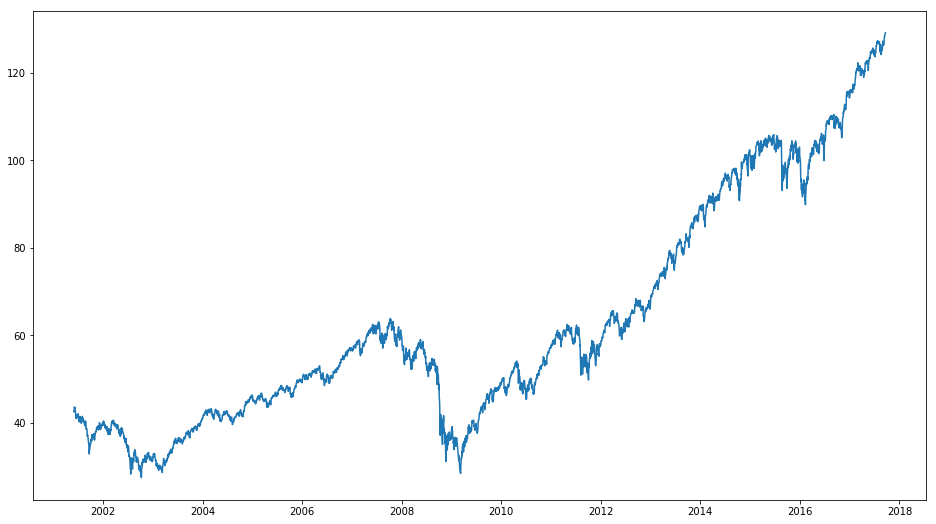

In [3]:
timeseries, dates = load_close('stockdatas/VTI.csv')
dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
plt.plot(dates, timeseries)

In [4]:
TRAIN_SIZE = 120 # train size for 6 month financial data
TARGET_TIME = 20 # predict for 20 financial days or a month
LAG_SIZE = 1
EMB_SIZE = 1

X, Y = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=False, scale=False)
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, percentage=0.9)

Xp, Yp = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=False, scale=False)
Xp, Yp = np.array(Xp), np.array(Yp)
X_trainp, X_testp, Y_trainp, Y_testp = create_Xt_Yt(Xp, Yp, percentage=0.9)

In [14]:
model = Sequential()
model.add(Dense(500, input_dim= (TRAIN_SIZE)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(optimizer='adam', 
              loss='mse')

model.fit(X_train, 
          Y_train, 
          epochs=5, 
          batch_size = 128, 
          verbose=2, 
          validation_split=0.2)
score = model.evaluate(X_test, Y_test, verbose=2)
print("\nScore :",score)

ValueError: Error when checking input: expected dense_10_input to have shape (None, 120) but got array with shape (3566, 139)

In [ ]:

params = []
for xt in X_testp:
    xt = np.array(xt)
    mean_ = xt.mean()
    scale_ = xt.std()
    params.append([mean_, scale_])

predicted = model.predict(X_test)
new_predicted = []

for pred, par in zip(predicted, params):
    a = pred*par[1]
    a += par[0]
    new_predicted.append(a)
    

mse = mean_squared_error(predicted, new_predicted)
print ("Mean Squared Error : ",mse)

try:
    #plt.plot(Y_test[:150], color='black') # BLACK - trained RESULT
    plt.plot(predicted[:150], color='blue') # BLUE - trained PREDICTION
    plt.plot(Y_testp[:150], color='green') # GREEN - actual RESULT
    #plt.plot(new_predicted[:150], color='red') # RED - restored PREDICTION
    plt.show()
except Exception as e:
    print (str(e))

# Regression problem - RNN

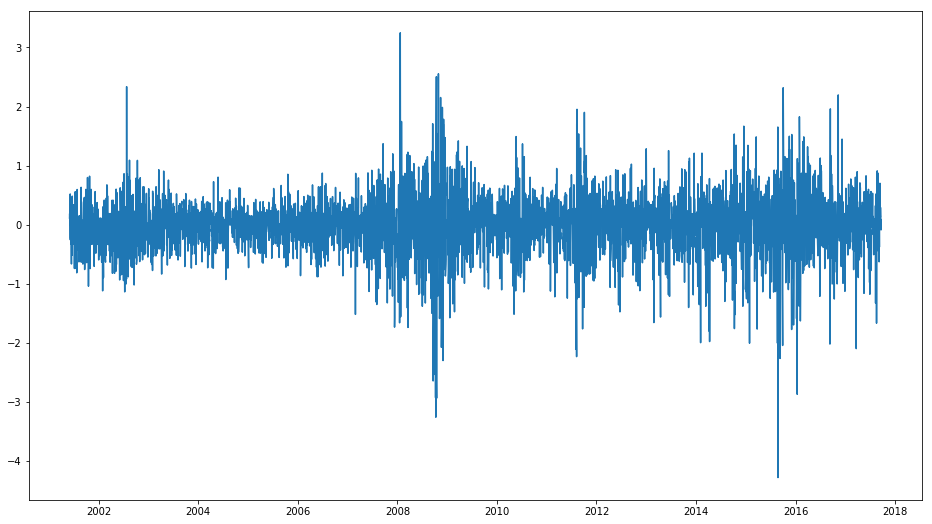

In [15]:
timeseries, dates = load_returns('stockdatas/VTI.csv')
dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
plt.plot(dates, timeseries)

In [16]:
TRAIN_SIZE = 30
TARGET_TIME = 1
LAG_SIZE = 1
EMB_SIZE = 1
HIDDEN_RNN = 4

X, Y = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=True, scale=True)

print (len(X), len(Y))

X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, percentage=0.9)

4072 4072


In [17]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))

model = Sequential()

#model.add(LSTM(input_shape = (EMB_SIZE,), input_dim=EMB_SIZE, output_dim=HIDDEN_RNN, return_sequences=True))
#model.add(LSTM(input_shape = (EMB_SIZE,), input_dim=EMB_SIZE, output_dim=HIDDEN_RNN, return_sequences=False))

model.add(LSTM(units=4, return_sequences=True, input_shape=(None, EMB_SIZE)))
model.add(LSTM(units=4, return_sequences=False, input_shape=(None, EMB_SIZE)))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(optimizer='adam', 
              loss='mse',
              metrics=['accuracy'])

In [18]:
model.fit(X_train, 
          Y_train, 
          epochs=5, 
          batch_size = 128, 
          verbose=1, 
          validation_split=0.1)


score = model.evaluate(X_test, Y_test, batch_size=128)
print ("\nScore :",score)

Train on 3297 samples, validate on 367 samples
Epoch 1/5
3297/3297 [==============================] - 1s - loss: 0.2504 - acc: 0.4986 - val_loss: 0.2491 - val_acc: 0.5014
Epoch 2/5
3297/3297 [==============================] - 0s - loss: 0.2502 - acc: 0.5056 - val_loss: 0.2490 - val_acc: 0.5368
Epoch 3/5
3297/3297 [==============================] - 0s - loss: 0.2502 - acc: 0.5050 - val_loss: 0.2491 - val_acc: 0.5286
Epoch 4/5
3297/3297 [==============================] - 0s - loss: 0.2502 - acc: 0.4980 - val_loss: 0.2491 - val_acc: 0.5450
Epoch 5/5
128/408 [========>.....................] - ETA: 0s
Score : [0.25023960132224887, 0.49509803921568629]


In [20]:
timeseries, dates = load_returns('stockdatas/VTI.csv')
X, Y = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=True)
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, percentage=0.9)

Y_train, Y_test = np.array([y.argmax() for y in Y_train]), np.array([y.argmax() for y in Y_test])


from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics, svm
from sklearn import linear_model

print ('Training...')

classifier = RandomForestClassifier(n_estimators = 100,
                               n_jobs=4,
                              verbose=1)

#classifier = linear_model.LogisticRegression(C=1e-5)

#classifier = svm.SVC()
classifier.fit(X_train, Y_train)

print ('Prediction...')
predicted = classifier.predict(X_test)
print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(Y_test, predicted)))

Training...


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s


Prediction...
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False):
             precision    recall  f1-score   support

          0       0.39      0.53      0.45       176
          1       0.51      0.38      0.43       232

avg / total       0.46      0.44      0.44       408




[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


# Classification problem - MLP

In [21]:
TRAIN_SIZE = 120 # 20 days close prices
TARGET_TIME = 20 # predict the 21th day
LAG_SIZE = 1
EMB_SIZE = 1

X, Y = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=True, scale=True)
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, percentage=0.9)

Xp, Yp = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=True, scale=True)
Xp, Yp = np.array(Xp), np.array(Yp)
X_trainp, X_testp, Y_trainp, Y_testp = create_Xt_Yt(Xp, Yp, percentage=0.9)

In [22]:
model = Sequential()
model.add(Dense(500, input_shape = (TRAIN_SIZE, )))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(optimizer='adam', 
			  loss='binary_crossentropy', 
			  metrics=['accuracy'])

In [23]:
history = model.fit(X_train, 
          Y_train, 
          epochs=5, 
          batch_size = 128, 
          verbose=1, 
          validation_split=0.1)

Train on 3209 samples, validate on 357 samples
Epoch 1/5
3209/3209 [==============================] - 0s - loss: 0.7532 - acc: 0.4902 - val_loss: 0.7177 - val_acc: 0.4986
Epoch 2/5
3209/3209 [==============================] - 0s - loss: 0.6526 - acc: 0.6105 - val_loss: 0.7106 - val_acc: 0.4986
Epoch 3/5
3209/3209 [==============================] - 0s - loss: 0.6163 - acc: 0.6697 - val_loss: 0.7264 - val_acc: 0.4986
Epoch 4/5
3209/3209 [==============================] - 0s - loss: 0.5643 - acc: 0.7205 - val_loss: 0.7509 - val_acc: 0.4874
Epoch 5/5
3209/3209 [==============================] - 0s - loss: 0.5188 - acc: 0.7582 - val_loss: 0.7699 - val_acc: 0.4790


In [24]:
scores = model.evaluate(X_test, Y_test, verbose=1)
print("\nModel Accuracy: %.2f%%" % (scores[1]*100))

 32/397 [=>............................] - ETA: 0s
Model Accuracy: 47.10%


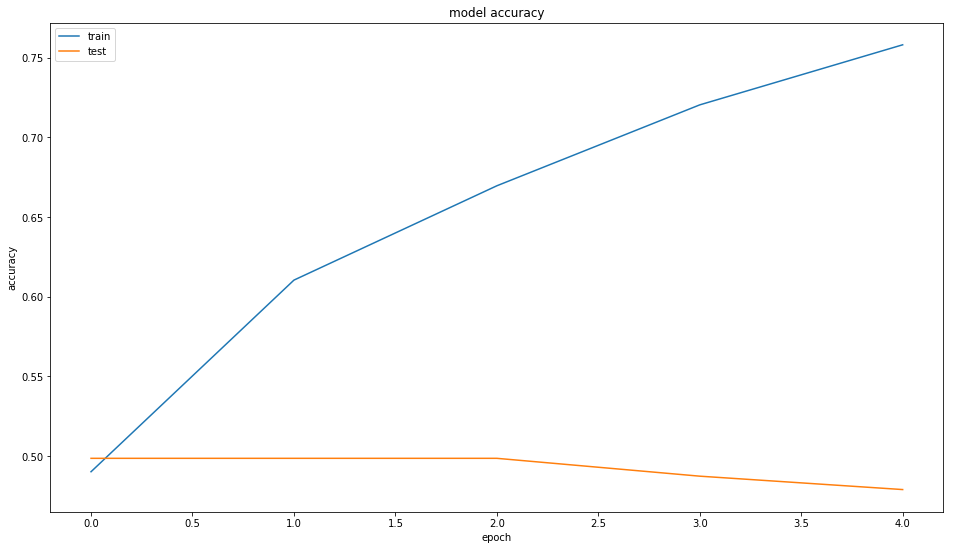

In [25]:
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# Classification problem - CNN

In [34]:
model = Sequential()
# model.add(Convolution1D(input_shape = (TRAIN_SIZE, EMB_SIZE), 
#                         nb_filter=64,
#                         filter_length=2,
#                         border_mode='valid',
#                         activation='relu',
#                         subsample_length=1))

model.add(Convolution1D(kernel_size=2, 
                 input_shape=(TRAIN_SIZE, EMB_SIZE), 
                 padding="valid", filters=64, 
                 activation="relu", strides=1))
#model.add(MaxPooling1D(pool_length=2))
model.add(MaxPooling1D(pool_size=2))

# model.add(Convolution1D(input_shape = (TRAIN_SIZE, EMB_SIZE), 
#                         nb_filter=64,
#                         filter_length=2,
#                         border_mode='valid',
#                         activation='relu',
#                         subsample_length=1))
model.add(Convolution1D(kernel_size=2, 
                 input_shape=(TRAIN_SIZE, EMB_SIZE), 
                 padding="valid", filters=64, 
                 activation="relu", strides=1))
#model.add(MaxPooling1D(pool_length=2))
model.add(MaxPooling1D(pool_size=2))

model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(250))
model.add(Dropout(0.25))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

history = TrainingHistory()

model.compile(optimizer='adam', 
			  loss='binary_crossentropy', 
			  metrics=['accuracy'])

In [35]:
model.fit(X_train, Y_train, epochs=3, batch_size=64)

# Evaluation on the test set
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

ValueError: Error when checking input: expected conv1d_5_input to have 3 dimensions, but got array with shape (3566, 120)

# Regression CNN

In [36]:
def make_timeseries_regressor(window_size, filter_length, nb_input_series=1, nb_outputs=1, nb_filter=4):
    """:Return: a Keras Model for predicting the next value in a timeseries given a fixed-size lookback window of previous values.
    The model can handle multiple input timeseries (`nb_input_series`) and multiple prediction targets (`nb_outputs`).
    :param int window_size: The number of previous timeseries values to use as input features.  Also called lag or lookback.
    :param int nb_input_series: The number of input timeseries; 1 for a single timeseries.
      The `X` input to ``fit()`` should be an array of shape ``(n_instances, window_size, nb_input_series)``; each instance is
      a 2D array of shape ``(window_size, nb_input_series)``.  For example, for `window_size` = 3 and `nb_input_series` = 1 (a
      single timeseries), one instance could be ``[[0], [1], [2]]``. See ``make_timeseries_instances()``.
    :param int nb_outputs: The output dimension, often equal to the number of inputs.
      For each input instance (array with shape ``(window_size, nb_input_series)``), the output is a vector of size `nb_outputs`,
      usually the value(s) predicted to come after the last value in that input instance, i.e., the next value
      in the sequence. The `y` input to ``fit()`` should be an array of shape ``(n_instances, nb_outputs)``.
    :param int filter_length: the size (along the `window_size` dimension) of the sliding window that gets convolved with
      each position along each instance. The difference between 1D and 2D convolution is that a 1D filter's "height" is fixed
      to the number of input timeseries (its "width" being `filter_length`), and it can only slide along the window
      dimension.  This is useful as generally the input timeseries have no spatial/ordinal relationship, so it's not
      meaningful to look for patterns that are invariant with respect to subsets of the timeseries.
    :param int nb_filter: The number of different filters to learn (roughly, input patterns to recognize).
    """
    model = Sequential((
        # The first conv layer learns `nb_filter` filters (aka kernels), each of size ``(filter_length, nb_input_series)``.
        # Its output will have shape (None, window_size - filter_length + 1, nb_filter), i.e., for each position in
        # the input timeseries, the activation of each filter at that position.
        Convolution1D(nb_filter=nb_filter, filter_length=filter_length, activation='relu', input_shape=(window_size, nb_input_series)),
        MaxPooling1D(),     # Downsample the output of convolution by 2X.
        Convolution1D(nb_filter=nb_filter, filter_length=filter_length, activation='relu'),
        MaxPooling1D(),
        Flatten(),
        Dense(nb_outputs, activation='linear'),     # For binary classification, change the activation to 'sigmoid'
    ))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    # To perform (binary) classification instead:
    # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    return model


def make_timeseries_instances(timeseries, window_size):
    """Make input features and prediction targets from a `timeseries` for use in machine learning.
    :return: A tuple of `(X, y, q)`.  `X` are the inputs to a predictor, a 3D ndarray with shape
      ``(timeseries.shape[0] - window_size, window_size, timeseries.shape[1] or 1)``.  For each row of `X`, the
      corresponding row of `y` is the next value in the timeseries.  The `q` or query is the last instance, what you would use
      to predict a hypothetical next (unprovided) value in the `timeseries`.
    :param ndarray timeseries: Either a simple vector, or a matrix of shape ``(timestep, series_num)``, i.e., time is axis 0 (the
      row) and the series is axis 1 (the column).
    :param int window_size: The number of samples to use as input prediction features (also called the lag or lookback).
    """
    timeseries = np.asarray(timeseries)
    assert 0 < window_size < timeseries.shape[0]
    X = np.atleast_3d(np.array([timeseries[start:start + window_size] for start in range(0, timeseries.shape[0] - window_size)]))
    y = timeseries[window_size:]
    q = np.atleast_3d([timeseries[-window_size:]])
    return X, y, q


def evaluate_timeseries(timeseries, window_size):
    """Create a 1D CNN regressor to predict the next value in a `timeseries` using the preceding `window_size` elements
    as input features and evaluate its performance.
    :param ndarray timeseries: Timeseries data with time increasing down the rows (the leading dimension/axis).
    :param int window_size: The number of previous timeseries values to use to predict the next.
    """
    filter_length = 5
    nb_filter = 4
    timeseries = np.atleast_2d(timeseries)
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T       # Convert 1D vectors to 2D column vectors

    nb_samples, nb_series = timeseries.shape
    print('\n\nTimeseries ({} samples by {} series):\n'.format(nb_samples, nb_series), timeseries)
    model = make_timeseries_regressor(window_size=window_size, filter_length=filter_length, nb_input_series=nb_series, nb_outputs=nb_series, nb_filter=nb_filter)
    print('\n\nModel with input size {}, output size {}, {} conv filters of length {}'.format(model.input_shape, model.output_shape, nb_filter, filter_length))
    model.summary()

    X, y, q = make_timeseries_instances(timeseries, window_size)
    print('\n\nInput features:', X, '\n\nOutput labels:', y, '\n\nQuery vector:', q, sep='\n')
    test_size = int(0.01 * nb_samples)           # In real life you'd want to use 0.2 - 0.5
    X_train, X_test, y_train, y_test = X[:-test_size], X[-test_size:], y[:-test_size], y[-test_size:]
    model.fit(X_train, y_train, nb_epoch=25, batch_size=2, validation_data=(X_test, y_test))

    pred = model.predict(X_test)
    print('\n\nactual', 'predicted', sep='\t')
    for actual, predicted in zip(y_test, pred.squeeze()):
        print(actual.squeeze(), predicted, sep='\t')
    print('next', model.predict(q).squeeze(), sep='\t')
    
evaluate_timeseries(timeseries, 120)



Timeseries (4103 samples by 1 series):
 [[ 0.08      ]
 [-0.09      ]
 [ 0.06      ]
 ..., 
 [ 0.        ]
 [ 0.18521905]
 [ 0.11113143]]


Model with input size (None, 120, 1), output size (None, 1), 4 conv filters of length 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 116, 4)            24        
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 58, 4)             0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 54, 4)             84        
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 27, 4)             0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 108)               0         
____________________________________________

/home/ros/anaconda3/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=4, input_shape=(120, 1), activation="relu", kernel_size=5)`
/home/ros/anaconda3/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=4, activation="relu", kernel_size=5)`
/home/ros/anaconda3/envs/research/lib/python3.5/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 3942 samples, validate on 41 samples
Epoch 1/25
3942/3942 [==============================] - 4s - loss: 0.2835 - mean_absolute_error: 0.3766 - val_loss: 0.1586 - val_mean_absolute_error: 0.3369
Epoch 2/25
3942/3942 [==============================] - 3s - loss: 0.2727 - mean_absolute_error: 0.3686 - val_loss: 0.1586 - val_mean_absolute_error: 0.3372
Epoch 3/25
3942/3942 [==============================] - 3s - loss: 0.2709 - mean_absolute_error: 0.3664 - val_loss: 0.1595 - val_mean_absolute_error: 0.3380
Epoch 4/25
3942/3942 [==============================] - 4s - loss: 0.2701 - mean_absolute_error: 0.3665 - val_loss: 0.1588 - val_mean_absolute_error: 0.3374
Epoch 5/25
3942/3942 [==============================] - 3s - loss: 0.2683 - mean_absolute_error: 0.3654 - val_loss: 0.1575 - val_mean_absolute_error: 0.3384
Epoch 6/25
3942/3942 [==============================] - 4s - loss: 0.2664 - mean_absolute_error: 0.3645 - val_loss: 0.1577 - val_mean_absolute_error: 0.3384
Epoch 7/25
3

# Conclusion

Threating financial time series prediction as regression problem is better approach, it can learn the trend and prices close to the actual.

MLPs are treating sequence data better as CNNs or RNNs which are supposed to work better with time series.

future works :
- Using different features (not only scaled time series) like techincal indicators, volume of sales
- Try frequent data, minute-by minute to have more training data